<h1><center>Comparitive Study on Sentiment Analysis Algorithms</center></h1>

---

### Introduction

- **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more.


- **Sentiment Analysis:** It is the interpretation and classification of emotions (positive and negative) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

### 1. Importing Packages

In [1]:
# utilities
import re
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score

-------

### 2. Importing Dataset

The dataset being used is the **sentiment140 dataset**. It contains 16,00,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

It contains the following 6 fields:

1. **sentiment:** The polarity of the tweet. (0 = negative, 4 = positive)
2. **ids:** The id of the tweet.
3. **date:** the date of the tweet. (Sat April 22 14:32:10 UTC 2008)
4. **query:** The query. If there is no query, then this value is NO_QUERY.
5. **user:** The name of the user that tweeted. (max129)
6. **text:** The text of the tweet.

Total length of the data is:      1600000
No. of positve tagged tweets is:  800000
No. of negative tagged tweets is: 800000


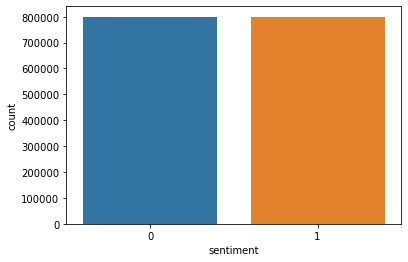

In [2]:
df = pd.read_csv('./twitter-data.csv',encoding='latin', names = ['sentiment','ids','date','query','user','text'])

# Removing unnecessary columns
df = df[['sentiment','text']]

# Replacing 4 with 1 for better readability
df['sentiment']=df['sentiment'].replace(4,1) #Now 0 = Negative and 1 = Positive

# Counting the number of Positive tagged and Negative tagged tweets
positives = df['sentiment'][df.sentiment == 1 ]
negatives = df['sentiment'][df.sentiment == 0 ]

print(f'Total length of the data is:      {df.shape[0]}')
print(f'No. of positve tagged tweets is:  {len(positives)}')
print(f'No. of negative tagged tweets is: {len(negatives)}')

# Plotting
sns.countplot(df['sentiment'])

In [3]:
# Head of the data
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


-------

### 3. Data Preprocessing and Cleaning

Data preprocessing transforms text into a more usable form so that machine learning algorithms can perform better.

The preprocessing steps that are taken are:

1. Converting the text into lower case
2. Replacing URLs with "URL"
3. Replacing Emojis with their meanings using a dictionary (Eg. ":)" to "EMOJIsmile")
4. Replacing @Usernames with the word "USER"
5. Removing all characters except alphabets
6. Replacing 3 or more repeating letters with 2 letters (Eg. "Heyyyy" to "Heyy")
7. Removing words having length less than 2
8. Removing stopwords
9. Lemmatizing i.e. converting a word to its base form (Eg. "Great" to "Good")

In [4]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised', ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [5]:
# Checking if any null values present
(df.isnull().sum() / len(df))*100

sentiment    0.0
text         0.0
dtype: float64

In [6]:
# Importing stopwords from nltk library
stopwordlist = set(stopwords.words('english'))
print(stopwordlist)

{"you've", 'has', 'why', "doesn't", 'below', 'that', "didn't", "shouldn't", 'himself', 'as', 'should', 'when', "should've", 'because', 'my', 'wasn', "you'd", 'then', 'between', "that'll", "hadn't", "you're", 'myself', "she's", 'how', 'out', 'i', 'did', 'couldn', "weren't", 'are', 'few', 's', 'if', 'can', 'too', 'you', 'after', 'not', 'so', 'them', 'who', 'an', 'its', 'this', 'does', 'more', 'needn', 'a', 'once', 'mightn', 'won', 'about', 'any', 'under', 'both', 'most', 'ain', 'those', 'no', 't', "don't", 'through', 'ourselves', 'your', 'shouldn', "needn't", 'and', 'don', 'be', 'all', 'against', 'while', 'here', 'on', "isn't", 'or', 'itself', 'very', 'aren', "couldn't", 'yours', 'other', 'they', 'being', 'm', 'of', 'at', 'was', 'having', 'their', 'some', "wasn't", 'have', 'were', 'mustn', 'there', 'd', 'each', 'themselves', 'what', 'such', 'by', 'to', 'before', 'yourselves', 'than', 'll', 'the', 'she', 'but', 'into', 'own', 'his', 'is', 'now', 'with', 'during', 'these', "hasn't", 'above

In [7]:
def preProcessData(data):
    processedText = []
    
    # Converting pandas object to a string type
    data['text'] = data['text'].astype('str')
    
    # Create Lemmatizer
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns
    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = r'@[^\s]+'
    alphaPattern = r"[^a-zA-Z0-9]"
    sequencePattern = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in data['text']:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL', tweet)
        
        # Replace all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        # Tokenizing words
        tokens = word_tokenize(tweet)
        
        # Removing Stop Words
        final_tokens = [w for w in tokens if w not in stopwordlist]
        
        # Lemmatizing
        wordLemm = WordNetLemmatizer()
        tweetwords = ''
        
        for w in final_tokens:
            if len(w)>1:
                word = wordLemm.lemmatize(w)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText 

In [8]:
import time
t = time.time()
processedtext = preProcessData(df)
print('Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 246 seconds


In [9]:
df['processed text'] = processedtext
df.head()

,sentiment,text,processed text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",USER URL aww bummer shoulda got david carr thi...
1,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,@Kenichan I dived many times for the ball. Man...,USER dived many time ball managed save 50 rest...
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",USER behaving mad see


----

### 4. Word-Cloud for tweets

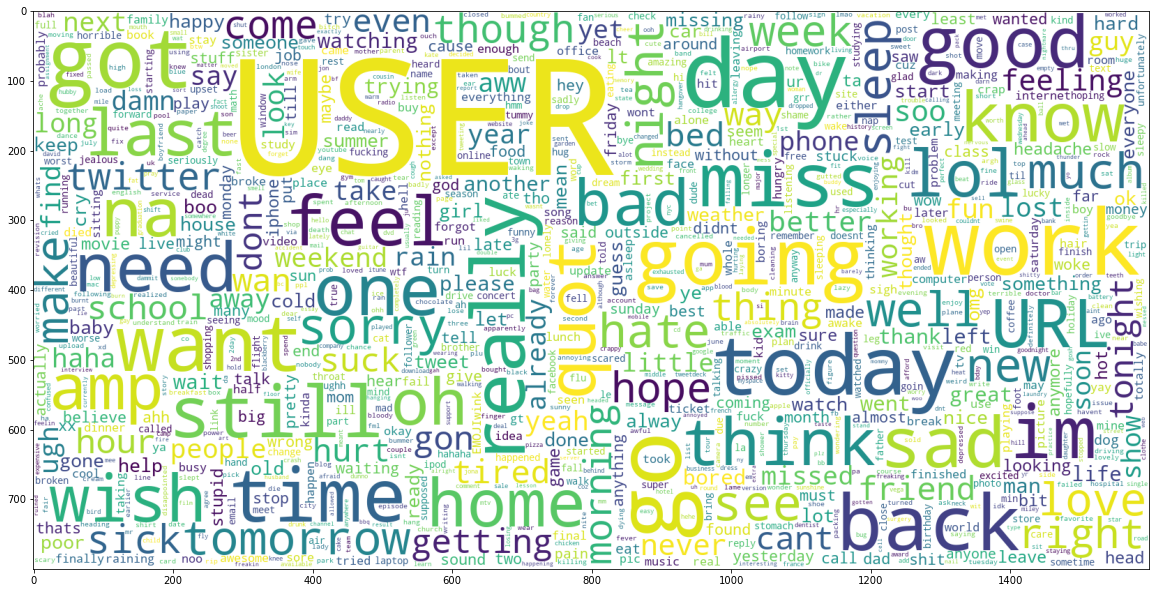

In [10]:
# Word-Cloud for Negative Tweets
data_neg = processedtext[:800000]

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color='white', contour_color='steelblue', collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

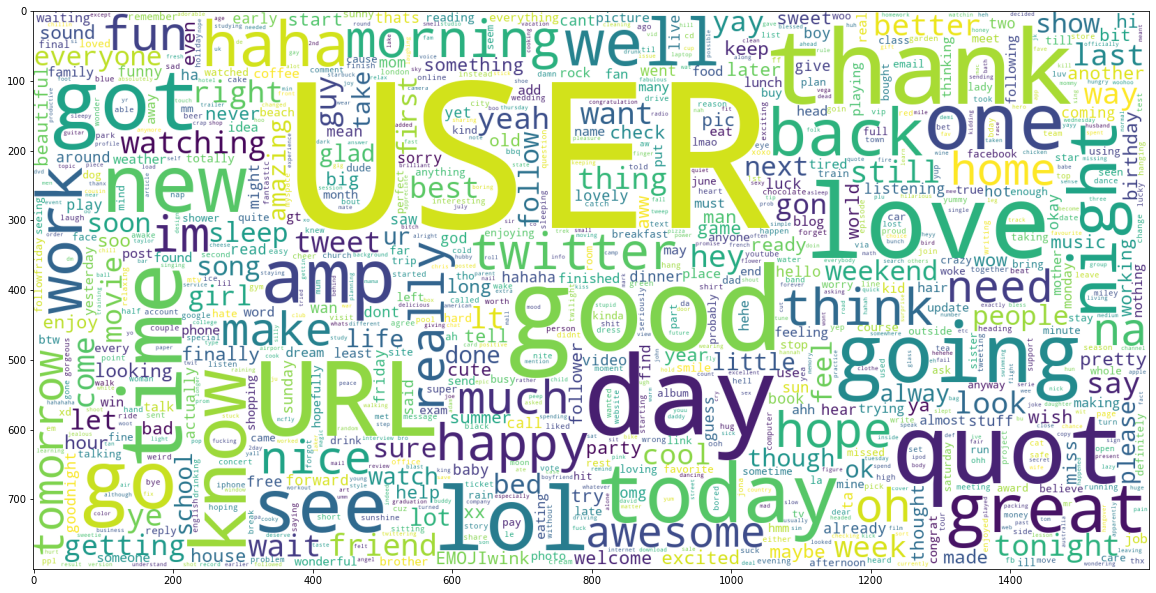

In [11]:
# Word-Cloud for Positive Tweets
data_neg = processedtext[800000:]

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, background_color='white', contour_color='steelblue', collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

----

### 5. TF-IDF Vectorization and Splitting the Data

**TF-IDF (Term Frequency - Inverse Document Frequency)** indicates what the importance of the word is in order to understand the document or dataset.

TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

In [12]:
X = df['processed text'].values
y = df['sentiment'].values

print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 6)
print(f'Data Split done.')
print()
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()

# Fitting the TF-IDF vectorizer only on the X_train dataset
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

(1600000,)
(1600000,)
Data Split done.

X_train (1440000,)
y_train (1440000,)

X_test (160000,)
y_test (160000,)

Vectoriser fitted.
No. of feature_words:  500000


In [13]:
# Transforming the dataset
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


----

### 6. Creating and Evaluating Models

We're creating 3 different types of model for our sentiment analysis problem:

- **Bernoulli Naive Bayes (BernoulliNB)**
- **Linear Support Vector Classification (LinearSVC)**
- **Logistic Regression (LR)**


In [14]:
# Defining the Model Evaluation function for different models
f1_scores = {}

def modelEvaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    import seaborn as sn
    plt.figure(figsize = (10,7))
    sns.heatmap(cf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    
    return f1_score(y_test, y_pred)

#### a) BernoulliNB Model

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     79928
           1       0.78      0.79      0.78     80072

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000

Time Taken for building and evaluating model: 1 seconds


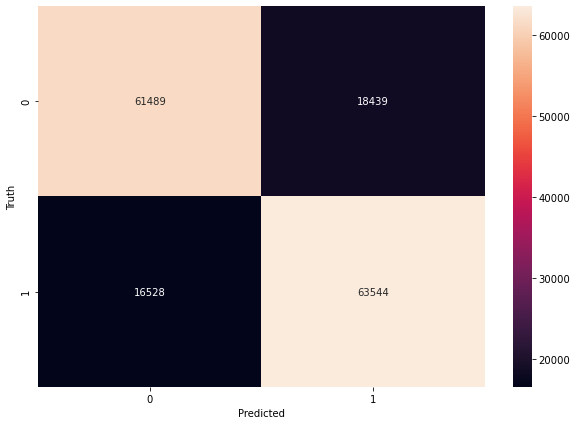

In [15]:
t = time.time()

BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
f1 = modelEvaluate(BNBmodel)
f1_scores['Bernoulli NB'] = f1

print(f'Time Taken for building and evaluating model: {round(time.time()-t)} seconds')

#### b) LinearSVC Model

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     79928
           1       0.78      0.79      0.78     80072

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000

Time Taken for building and evaluating model: 26 seconds


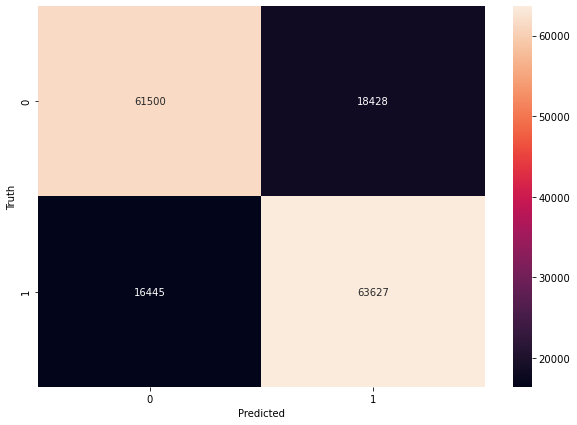

In [16]:
t = time.time()

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
f1 = modelEvaluate(SVCmodel)
f1_scores['Linear SVC'] = f1

print(f'Time Taken for building and evaluating model: {round(time.time()-t)} seconds')

#### c) Logistic Regression Model

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     79928
           1       0.79      0.81      0.80     80072

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000

Time Taken for building and evaluating model: 136 seconds


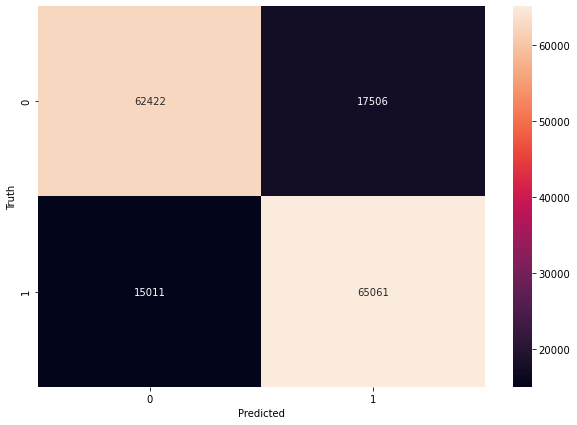

In [17]:
t = time.time()

LRmodel = LogisticRegression(max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
f1 = modelEvaluate(LRmodel)
f1_scores['Logistic Regression'] = f1

print(f'Time Taken for building and evaluating model: {round(time.time()-t)} seconds')

In [19]:
# Model with best F1 Score
print("F1 scores of the 3 models :")
print(f1_scores)
print()

keymax = max(f1_scores, key=f1_scores.get)
valuemax = max(f1_scores.values())
print("Best model is", keymax, "with F1 score =", valuemax)

F1 scores of the 3 models :
{'Bernoulli NB': 0.7842275770571719, 'Linear SVC': 0.7849031931757204, 'Logistic Regression': 0.8000664047368712}

Best model is Logistic Regression with F1 score = 0.8000664047368712


It can clearly be seen that the Logistic Regression Model performs the best out of all the three different models that we tried. It achieves nearly 80% accuracy while classifying the sentiment of a tweet.

Although it should also be noted that the BernoulliNB Model is the fastest to train and predict on. It also achieves 78% accuracy while calssifying the sentiment of a tweet.

-----

### 7. Using the BNB Model

In [20]:
text = ['I hate twitter.','I love twitter.']
mydf = pd.DataFrame (text, columns=['text'])

textdata = vectoriser.transform(preProcessData(mydf))
sentiment = BNBmodel.predict(textdata)

In [21]:
# Make a list of text along with predicted sentiment.
data = []
for text, pred in zip(text, sentiment):
    data.append((text,pred))

# Convert the list into a Pandas DataFrame.
newdf = pd.DataFrame(data, columns = ['text','sentiment'])
newdf = newdf.replace([0,1], ["Negative","Positive"])

In [22]:
print("Predicted sentiment is as follows:")
newdf

Predicted sentiment is as follows:


,text,sentiment
0,I hate twitter.,Negative
1,I love twitter.,Positive
